In [613]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,  StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline

In [614]:
DATA_NAME = "processed_spotify_songs"
DATA_PATH = f"../data/{DATA_NAME}.csv"
TARGET_COLUMN = "track_popularity"

In [615]:
df = pd.read_csv(DATA_PATH)

In [616]:
df.head()

,track_artist,track_popularity,track_album_id,track_album_release_date,playlist_id,playlist_subgenre,danceability,energy,key,loudness,...,rap,latin,rock,pop,artist_track_encoded,playlist_id_encoded,track_album_id_encoded,release_year,release_month,release_day
0,Barbie's Cradle,41.0,1srJQ0njEQgd8w4XSqI4JQ,2001-01-01,37i9dQZF1DWYDQ8wBxd7xt,classic rock,0.481351,0.160801,2.0,0.588413,...,0,0,1,0,43.5,43.100000,41.0,2001,1,1
1,RIKA,15.0,1ficfUnZMaY1QkNp15Slzm,2018-01-26,0JmBB9HfrzDiZoPVRdv8ns,neo soul,0.350541,0.495616,5.0,0.715122,...,0,0,0,0,15.0,26.206186,15.0,2018,1,26
2,Steady Rollin,28.0,3z04Lb9Dsilqw68SHt6jLB,2017-11-21,3YouF0u7waJnolytf9JCXf,hard rock,0.095012,0.774400,9.0,0.768273,...,0,0,1,0,29.5,31.697917,28.0,2017,11,21
3,The.madpix.project,24.0,1Z4ANBVuhTlS6DprlP0m1q,2015-08-07,5TiiHps0hNCyQ6ijVkNZQs,electropop,0.449432,0.630436,10.0,0.736041,...,0,0,0,1,12.2,39.436364,24.0,2015,8,7
4,YOSA & TAAR,38.0,2BuYm9UcKvI0ydXs5JKwt0,2018-11-16,37i9dQZF1DXdOtZGKonFlM,dance pop,0.453533,0.702244,1.0,0.713109,...,0,0,0,1,38.0,35.673469,38.0,2018,11,16


### A little pre-processing 

In [617]:
### REMOVE some useless columns
df = df.drop(columns=["track_artist","track_album_id","track_album_release_date","playlist_id","playlist_subgenre","playlist_id_encoded","artist_track_encoded","track_album_id_encoded"])

In [618]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28352 entries, 0 to 28351
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_popularity  28352 non-null  float64
 1   danceability      28352 non-null  float64
 2   energy            28352 non-null  float64
 3   key               28352 non-null  float64
 4   loudness          28352 non-null  float64
 5   mode              28352 non-null  int64  
 6   speechiness       28352 non-null  float64
 7   acousticness      28352 non-null  float64
 8   instrumentalness  28352 non-null  float64
 9   liveness          28352 non-null  float64
 10  valence           28352 non-null  float64
 11  tempo             28352 non-null  float64
 12  duration_ms       28352 non-null  float64
 13  edm               28352 non-null  int64  
 14  r&b               28352 non-null  int64  
 15  rap               28352 non-null  int64  
 16  latin             28352 non-null  int64 

We have 24 predictors for 28000 samples, nice !

### Encode target variable (`track_popularity`) into 20 sub categories

In [619]:
num_categories = 3

bins = [i * (100 / num_categories) for i in range(num_categories + 1)]
labels = list(range(0, num_categories ))  
print(labels)

[0, 1, 2]


In [620]:
df['popularity_category'] = pd.cut(
    df['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df = df.drop(columns=["track_popularity"])

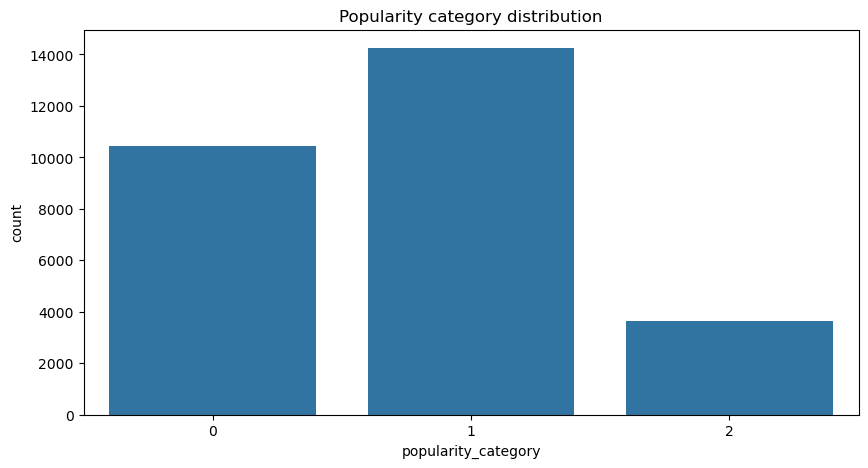

In [621]:
# plot distribution of popularity categories
plt.figure(figsize=(10, 5))
sns.countplot(x='popularity_category', data=df)
plt.title('Popularity category distribution')
plt.show()

### Split dateset

In [622]:
# Split the dataset before resampling
X = df.drop(columns=["popularity_category"])
y = df["popularity_category"]

X_train, X_test, y_train, y_test = train_test_split(
    # Maintain original class distribution in test set
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [623]:
results = []

#### Resample the train dataset

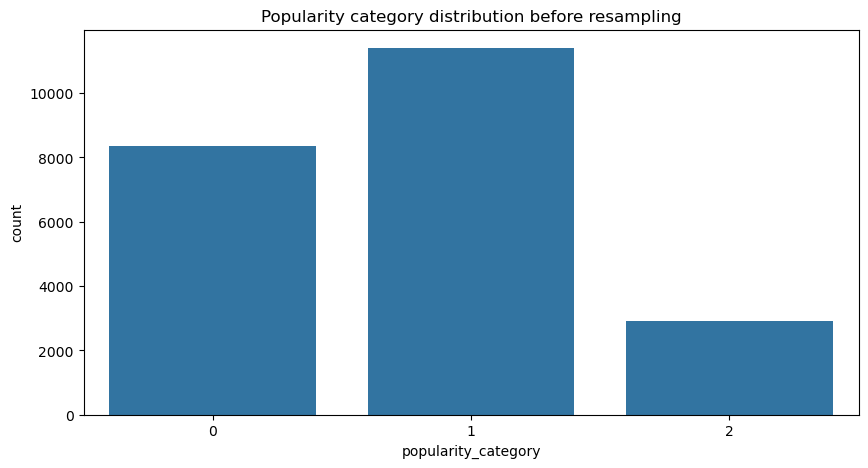

In [624]:
plt.figure(figsize=(10, 5))
sns.countplot(x='popularity_category', data=pd.DataFrame(
    y_train, columns=["popularity_category"]))
plt.title('Popularity category distribution before resampling')
plt.show()

In [625]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

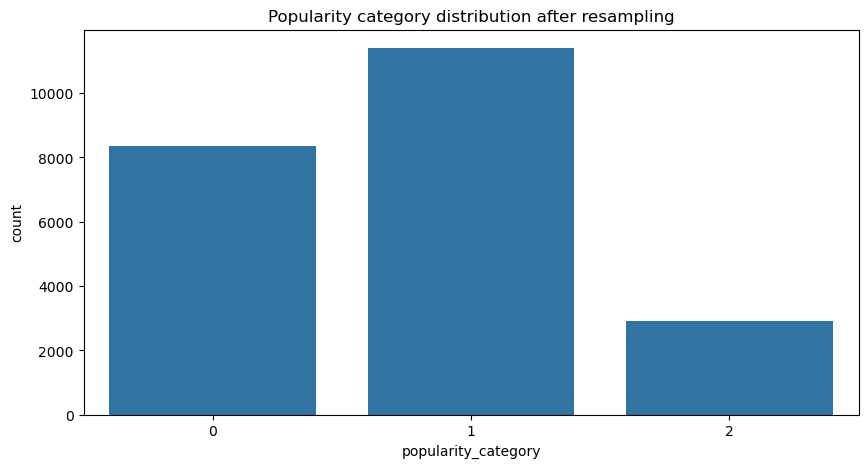

In [626]:
# plot befopre and after resampling


plt.figure(figsize=(10, 5))
sns.countplot(x='popularity_category', data=pd.DataFrame(y_train, columns=["popularity_category"]))
plt.title('Popularity category distribution after resampling')
plt.show()


### Pipeline definition

In [627]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

       # 1. Interaction Features
        X['energy_danceability'] = X['energy'] * X['danceability']
        X['tempo_energy_interaction'] = X['tempo'] * X['energy']
        X['dance_valence'] = X['danceability'] * X['valence']

        # 2. Log Transformations
        X['loudness_log'] = np.log1p(X['loudness'].clip(lower=1))
        X['instrumentalness_log'] = np.log1p(X['instrumentalness'])

        # 3. Temporal Features
        X['track_age'] = 2024 - X['release_year']
        X['release_season'] = X['release_month'].apply(self._categorize_season)

        # 4. Genre Features
        genre_cols = ['edm', 'r&b', 'rap', 'latin', 'rock', 'pop']
        X['genre_count'] = X[genre_cols].sum(axis=1)

        # 6. Frequency Encoding
        # freq_encoding = X['artist_track_encoded'].value_counts(normalize=True)
        # X['artist_track_freq'] = X['artist_track_encoded'].map(freq_encoding)

        # One-hot encode release season
        X = pd.get_dummies(X, columns=['release_season'], drop_first=True)

        # Drop unused columns if necessary (optional)
        X.drop(columns=['release_year', 'release_month',
               'release_day'], inplace=True, errors='ignore')

        return X

    @staticmethod
    def _categorize_season(month):
        """Helper function to map month to season."""
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

In [628]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

{0: 0.9045624950147563, 1: 0.663187134502924, 2: 2.586497890295359}


In [629]:
pipeline_decision_tree = ImbPipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42))
])

In [630]:
X_transformed = pipeline_decision_tree.named_steps['feature_engineering'].fit_transform(
    X_train)

X_transformed.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,energy_danceability,tempo_energy_interaction,dance_valence,loudness_log,instrumentalness_log,track_age,genre_count,release_season_Spring,release_season_Summer,release_season_Winter
513,0.599325,0.463761,2.0,0.707329,1,0.811181,0.422563,0.020015,0.854759,0.210898,...,0.277943,2.337166,0.126396,0.693147,0.019817,5,1,False,False,False
10607,0.569772,0.736164,8.0,0.776357,1,0.392479,0.215876,0.028578,0.418301,0.738648,...,0.419445,3.472941,0.420861,0.693147,0.028177,5,1,True,False,False
5300,0.718097,0.651249,8.0,0.788272,1,0.391771,0.193665,0.401636,0.492526,0.934410,...,0.467660,3.175721,0.670997,0.693147,0.337640,5,1,True,False,False
16730,0.423890,0.659344,10.0,0.781976,1,0.349230,0.533577,0.010823,0.482673,0.640767,...,0.279489,3.579060,0.271615,0.693147,0.010764,15,1,False,False,False
6703,0.577476,0.769129,9.0,0.803108,0,0.416654,0.335389,0.094280,0.616168,0.758829,...,0.444154,3.662647,0.438206,0.693147,0.090097,9,1,False,False,False


In [631]:
pipeline_rf = ImbPipeline(steps=[
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

pipeline_rf_without_feature_engineering = ImbPipeline(steps=[
    ('resampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

pipeline_rf_without_resampling = ImbPipeline(steps=[
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

In [632]:
pipeline_xgb = ImbPipeline(steps=[
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False,
     eval_metric='mlogloss', random_state=42))
])

### First model - DecisionTree

In [633]:
param_grid = {
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2'],
    'classifier__criterion': ['gini', 'entropy']
}

In [634]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline_decision_tree,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=cv,                
    n_jobs=-1,           
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy_decision_tree = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_decision_tree)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Best parameters found: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.43076635689929704
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.45      0.45      2090
           1       0.53      0.48      0.51      2850
           2       0.26      0.35      0.30       731

    accuracy                           0.45      5671
   macro avg       0.41      0.43      0.42      5671
weighted avg       0.47      0.45      0.46      5671

Accuracy: 0.45265385293599014


Text(0.5, 1.0, 'Confusion Matrix')

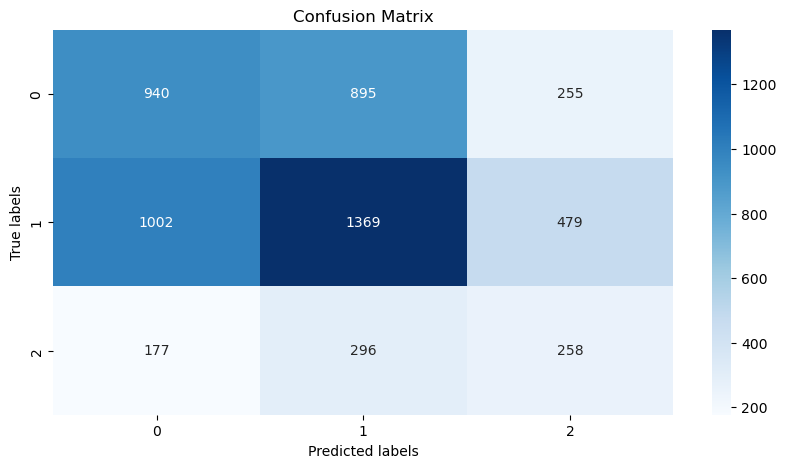

In [635]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')


In [636]:
results.append([f"Decisition Tree", accuracy_decision_tree])

### Second model - Random Forest

In [637]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit models
print("Starting Grid Search for RandomForestClassifier...")
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best F1 Macro Score for RandomForest:", grid_search_rf.best_score_)

# Evaluate on test set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

Starting Grid Search for RandomForestClassifier...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


Best Parameters for RandomForest: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best F1 Macro Score for RandomForest: 0.4988199863733467

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      2090
           1       0.60      0.57      0.58      2850
           2       0.35      0.46      0.39       731

    accuracy                           0.54      5671
   macro avg       0.50      0.52      0.50      5671
weighted avg       0.55      0.54      0.54      5671

Accuracy: 0.5372950096984659


In [638]:
results.append(["Random Forest", accuracy_rf])

In [639]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf_without_feature_engineering,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit models
print("Starting Grid Search for RandomForestClassifier...")
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best F1 Macro Score for RandomForest:", grid_search_rf.best_score_)

# Evaluate on test set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

Starting Grid Search for RandomForestClassifier...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for RandomForest: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best F1 Macro Score for RandomForest: 0.4907537329768192

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.55      0.50      0.53      2090
           1       0.60      0.58      0.59      2850
           2       0.32      0.44      0.37       731

    accuracy                           0.53      5671
   macro avg       0.49      0.51      0.50      5671
weighted avg       0.55      0.53      0.54      5671

Accuracy: 0.5346499735496385


In [640]:
results.append(["Random Forest without feature engineering", accuracy_rf])

In [641]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf_without_resampling,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit models
print("Starting Grid Search for RandomForestClassifier...")
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best F1 Macro Score for RandomForest:", grid_search_rf.best_score_)

# Evaluate on test set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

Starting Grid Search for RandomForestClassifier...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for RandomForest: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best F1 Macro Score for RandomForest: 0.5014058494277074

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.56      0.48      0.52      2090
           1       0.59      0.72      0.65      2850
           2       0.50      0.28      0.36       731

    accuracy                           0.57      5671
   macro avg       0.55      0.49      0.51      5671
weighted avg       0.57      0.57      0.56      5671

Accuracy: 0.5745018515253042


In [642]:
results.append(["Random Forest without resampling", accuracy_rf])

### Model 4 - Boosting

#### XGBoost

In [643]:
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


print("\nStarting Grid Search for XGBoostClassifier...")
grid_search_xgb.fit(X_train, y_train)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best F1 Macro Score for XGBoost:", grid_search_xgb.best_score_)




best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nClassification Report for XGBoostClassifier:")
print(classification_report(y_test, y_pred_xgb))

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy_xgb)


Starting Grid Search for XGBoostClassifier...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:19:55] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:19:55] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:19:55] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warning

Best Parameters for XGBoost: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}
Best F1 Macro Score for XGBoost: 0.5060681111076611

Classification Report for XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      2090
           1       0.60      0.57      0.59      2850
           2       0.35      0.45      0.39       731

    accuracy                           0.54      5671
   macro avg       0.50      0.52      0.51      5671
weighted avg       0.55      0.54      0.54      5671

Accuracy: 0.540821724563569


In [644]:
results.append(["XGB Classifier", accuracy_xgb])

### Results

In [645]:
df_results = pd.DataFrame(results, columns=["Model", "Accuracy"])
print(df_results)

# save resultr in txt file
df_results.to_csv(f"../results/{num_categories}_results_classfication_{DATA_NAME}.txt", index=False)

                                       Model  Accuracy
0                            Decisition Tree  0.452654
1                              Random Forest  0.537295
2  Random Forest without feature engineering  0.534650
3           Random Forest without resampling  0.574502
4                             XGB Classifier  0.540822
